# Hard Attention MNIST

This is jupyter notebook for `Hard Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random

In [2]:
# Import MNIST data

mat_data_train = scipy.io.loadmat('MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('MNIST_data_test_re.mat')

train_x = mat_data_train['X_train']
train_y = mat_data_train['Y_train']

test_x = mat_data_test['X_test'][:9900, :]
test_y = mat_data_test['Y_test'][:9900, :]

validation_x = mat_data_test['X_test'][9900:, :]
validation_y = mat_data_test['Y_test'][9900:, :]

del mat_data_train
del mat_data_test

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print("Validation data shape: " + str(validation_x.shape))
print("Validation label shape: " + str(validation_y.shape))

Train data shape: (55000, 112, 112)
Train label shape: (55000, 10)
Test data shape: (9900, 112, 112)
Test label shape: (9900, 10)
Validation data shape: (100, 112, 112)
Validation label shape: (100, 10)


## Parameters

In [3]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_name = 'hard1'

# Numbers of sampling to test the code 
num_test_sample = 10

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

# parameter for attention
img_fraction_size = 28
stride = 14

len_horizontal = int((img_size - img_fraction_size) / stride + 1)
len_vertical   = int((img_size - img_fraction_size) / stride + 1)
len_stack = len_horizontal * len_vertical

print("Horizontal Length: " + str(len_horizontal))
print("Vertical Length: " +str(len_vertical))
print("Window Length: " +str(len_stack))

Horizontal Length: 7
Vertical Length: 7
Window Length: 49


## Plotting Sample Image (Modified MNIST for Attention)

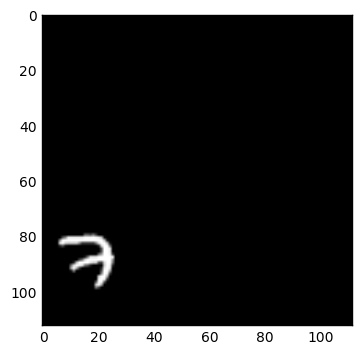

Label: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [4]:
# Plotting example image
img = train_x[0, :, :]
# img_resize = img.reshape((img_size, img_size))
plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))

## Plotting Sample Image Fractions

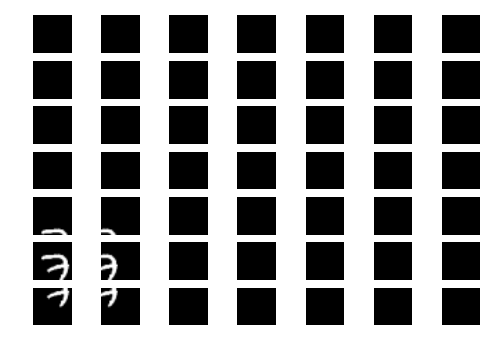

In [5]:
f, ax = plt.subplots(len_vertical, len_horizontal)

img_fraction = np.zeros([img_fraction_size, img_fraction_size, len_stack])
index_fraction = 0
for i in range(len_vertical):
    start_v = stride * i
    for j in range(len_horizontal):
        start_h = stride * j
                
        img_fraction[:,:,index_fraction] = img[start_v : start_v + img_fraction_size, 
                                               start_h : start_h + img_fraction_size]
        
        ax[i, j].imshow(img_fraction[:,:,index_fraction], cmap = 'gray')
        ax[i, j].axis('off')
        
        index_fraction += 1
        
plt.show()

In [6]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [7]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Soft Attention function
def hard_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Image windows after CNN. List of convolution window images 
    # (List len: number of windows, element shape: [batch_size, convolution flatten size])
    
    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))]
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)
    alpha = tf.nn.softmax(m_concat)
    alpha_argmax = tf.argmax(alpha, axis = 1)
    alpha_hard  = tf.one_hot(alpha_argmax, len_stack)
    
##     For Monte-Carlo Sampling
#     alpha_cumsum = tf.cumsum(alpha, axis = 1)
#     len_batch = tf.shape(alpha_cumsum)[0]
#     rand_prob = tf.random_uniform(shape = [len_batch, 1], minval = 0., maxval = 1.)
#     alpha_relu = tf.nn.relu(rand_prob - alpha_cumsum)
#     alpha_index = tf.count_nonzero(alpha_relu, 1)
#     alpha_hard  = tf.one_hot(alpha_index, len_stack)
    
    z_list = [tf.multiply(a[i], tf.slice(alpha_hard, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    #     return alpha_hard, z, alpha, alpha_cumsum, rand_prob, alpha_relu, alpha_index
    
    return alpha_hard, z, alpha
    

## Network

In [8]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_fraction_size, img_fraction_size, len_stack])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

x_unstack = tf.unstack(x_image, axis = 3)

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, 1, 32])
b_conv1 = bias_variable('b_conv1', [32])
w_conv2 = weight_variable('W_conv2', [1, 1, 32, 16])
b_conv2 = bias_variable('b_conv2', [16])

conv_list = []
for i in range(len_stack):
    x_conv = tf.reshape(x_unstack[i], (-1, img_fraction_size, img_fraction_size, 1))
    conv1 = tf.nn.relu(conv2d(x_conv, w_conv1, 2) + b_conv1)
    pool1 = max_pool_2x2(conv1)
    conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 1) + b_conv2)
    pool2 = max_pool_2x2(conv2)
    conv_result_flat = tf.contrib.layers.flatten(pool2)
    conv_list.append(conv_result_flat)

len_conv = int(conv_list[0].get_shape()[1])

#LSTM Variables
Wf = weight_variable('Wf', [len_conv + lstm_size, lstm_size])
Wi = weight_variable('Wi', [len_conv + lstm_size, lstm_size])
Wc = weight_variable('Wc', [len_conv + lstm_size, lstm_size])
Wo = weight_variable('Wo', [len_conv + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [len_conv, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha_hard, z, alpha = hard_attention(rnn_out, conv_list, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)
######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1

# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create Session

In [9]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [10]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state("saved_networks/")
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

## Training

In [11]:
# Training

if Is_train == True:
    train_data_num = train_x.shape[0]

    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]


            # Make image as fractions for attention
            train_fraction = np.zeros([batch_x_train.shape[0], img_fraction_size, img_fraction_size, len_stack])
            validation_fraction = np.zeros([validation_x.shape[0], img_fraction_size, img_fraction_size, len_stack])

            index_fraction = 0
            for m in range(len_vertical):
                start_v = stride * m
                for n in range(len_horizontal):
                    start_h = stride * n

                    train_fraction[:,:,:,index_fraction] = batch_x_train[:, 
                                                                         start_v : start_v + img_fraction_size, 
                                                                         start_h : start_h + img_fraction_size]

                    validation_fraction[:,:,:,index_fraction] = validation_x[:, 
                                                                            start_v : start_v + img_fraction_size, 
                                                                            start_h : start_h + img_fraction_size]
                    index_fraction += 1

            # Training
            optimizer.run(feed_dict = {x_image: train_fraction, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_fraction, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_fraction, y_target: batch_y_train})
            val_acc = sess.run(accuracy, feed_dict = {x_image: validation_fraction, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc) + ' / ' + 
                  "Validation Accuracy: " + str(val_acc))  

        saver.save(sess, 'saved_networks/' + save_name)
        print('Model is saved!!!')

Epoch: 1 / Batch: 0/55000 / Cost: 0.702318 / Training Accuracy: 0.132813 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 256/55000 / Cost: 0.652851 / Training Accuracy: 0.0742188 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 512/55000 / Cost: 0.603063 / Training Accuracy: 0.113281 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 768/55000 / Cost: 0.558249 / Training Accuracy: 0.0625 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 1024/55000 / Cost: 0.50767 / Training Accuracy: 0.105469 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 1280/55000 / Cost: 0.463038 / Training Accuracy: 0.0976563 / Validation Accuracy: 0.14
Epoch: 1 / Batch: 1536/55000 / Cost: 0.424006 / Training Accuracy: 0.0898438 / Validation Accuracy: 0.11
Epoch: 1 / Batch: 1792/55000 / Cost: 0.384546 / Training Accuracy: 0.121094 / Validation Accuracy: 0.07
Epoch: 1 / Batch: 2048/55000 / Cost: 0.359354 / Training Accuracy: 0.0976563 / Validation Accuracy: 0.09
Epoch: 1 / Batch: 2304/55000 / Cost: 0.341614 / Training Accuracy: 0.

## Testing

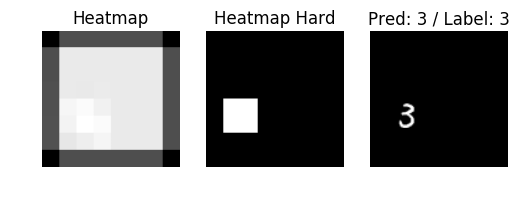

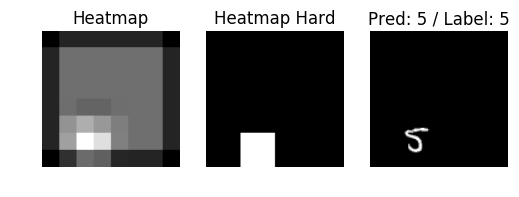

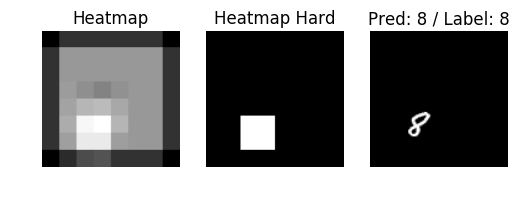

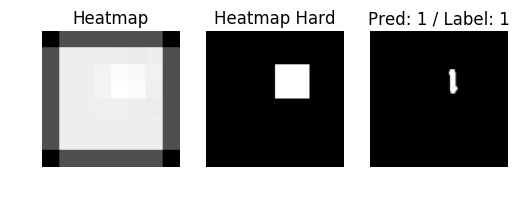

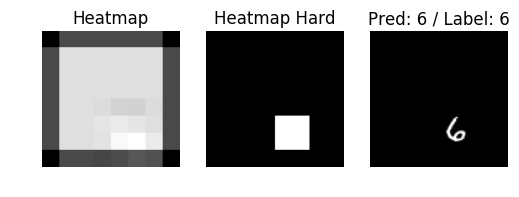

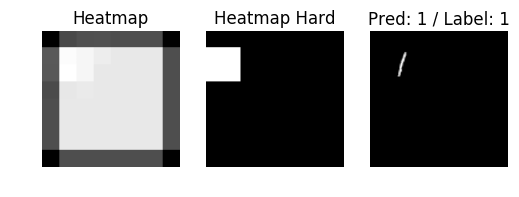

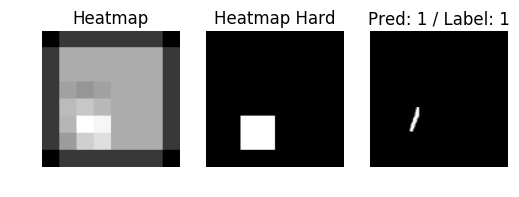

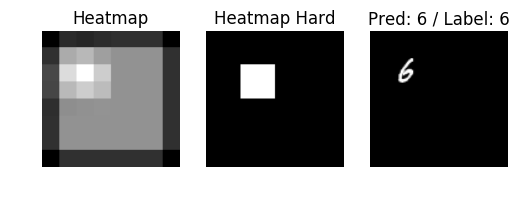

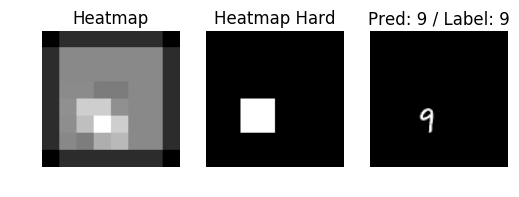

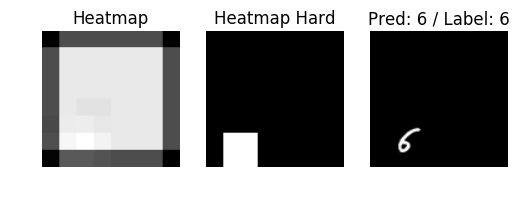

Sample Accuracy: 1.0


In [13]:
# Sampling test indexes
idx = random.sample(range(test_x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_fraction_size, img_fraction_size, len_stack])
heat_map = np.zeros([num_test_sample, img_size, img_size])
heat_map_hard = np.zeros([num_test_sample, img_size, img_size]) 
num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Making test fractions
    index_fraction = 0
    for m in range(len_vertical):
        start_v = stride * m
        for n in range(len_horizontal):
            start_h = stride * n

            test_fraction[idx_sample,:,:,index_fraction] = test_x[idx[idx_sample], 
                                                                  start_v : start_v + img_fraction_size, 
                                                                  start_h : start_h + img_fraction_size]

            index_fraction += 1

    # Get alpha(weight of fractions) and output for sample test data
    alpha_hard_, output_, z_, alpha_ = sess.run([alpha_hard, output, z, alpha],feed_dict = {x_image: [test_fraction[idx_sample,:,:,:]], y_target: [test_y[idx[idx_sample],:]]})
    
    alpha_hard_reshape = np.reshape(alpha_hard_, (1, len_vertical, len_horizontal))
    alpha_reshape = np.reshape(alpha_, (1, len_vertical, len_horizontal))

    # Make heatmap with alpha
    for i in range(len_vertical):
        for j in range(len_horizontal):
            heat_map[idx_sample, stride * i : (stride * i + img_fraction_size), stride * j : (stride * j + img_fraction_size)] += alpha_reshape[:, i, j]
            heat_map_hard[idx_sample, stride * i : (stride * i + img_fraction_size), stride * j : (stride * j + img_fraction_size)] += alpha_hard_reshape[:, i, j]

    heat_map[idx_sample,:,:] = heat_map[idx_sample,:,:] / np.max(heat_map[idx_sample,:,:])
    heat_map_hard[idx_sample,:,:] = heat_map_hard[idx_sample,:,:] / np.max(heat_map_hard[idx_sample,:,:])

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx[idx_sample], :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,3)
    ax[0].imshow(heat_map[idx_sample,:,:], cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Heatmap')
    ax[1].imshow(heat_map_hard[idx_sample,:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Heatmap Hard')    
    ax[2].imshow(test_x[idx[idx_sample],:,:], cmap='gray')
    ax[2].axis("off")
    ax[2].set_title('Pred: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))
    

    # Show results 
    plt.show()
    
    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

print('Sample Accuracy: ' + str(num_correct / num_test_sample))